In [2]:
#Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

In [5]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
#Create engine to connect to Hawaii SQLite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
#Inspect table to define columns and connect
inspector = inspect(engine)
inspector.get_table_names()
conn = engine.connect()

# Read tables into Pandas
measurement = pd.read_sql("SELECT * FROM measurement", conn)
station = pd.read_sql("SELECT * FROM station", conn)


#Merge tables together on station
measure_station = pd.merge(station,measurement, how = "left", on ="station")
measure_station

,id_x,station,name,latitude,longitude,elevation,id_y,date,prcp,tobs
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,1,2010-01-01,0.08,65.0
1,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2,2010-01-02,0.00,63.0
2,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,3,2010-01-03,0.00,74.0
3,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,4,2010-01-04,0.00,76.0
4,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,5,2010-01-06,NaN,73.0
...,...,...,...,...,...,...,...,...,...,...
19545,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,19546,2017-08-19,0.09,71.0
19546,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,19547,2017-08-20,NaN,78.0
19547,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,19548,2017-08-21,0.56,76.0
19548,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,19549,2017-08-22,0.50,76.0


In [8]:
#View all of the classes that automap found
measure_column = inspector.get_columns('measurement')
for m in measure_column:
    print(m['name'], m["type"])

station_column = inspector.get_columns('station')
for s in station_column:
    print(s['name'], s["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [40]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

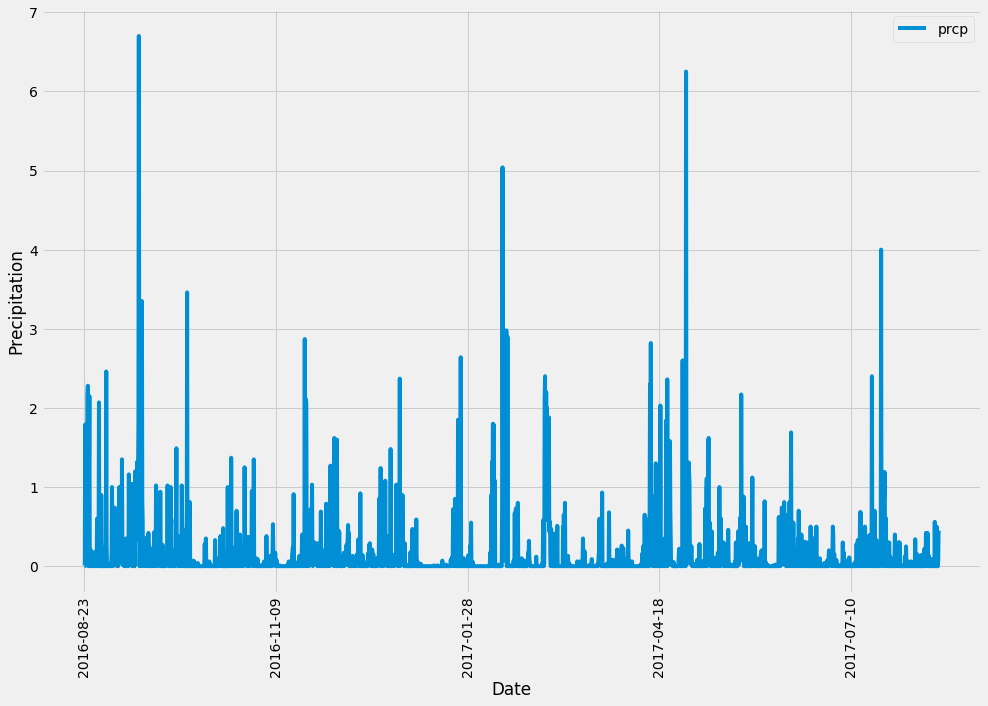

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain_results =session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= '2017-08-23').\
             filter(Measurement.date >= '2016-08-23').all()

rain_df = pd.DataFrame(rain_results, columns = ['date','prcp'])
rain_df = rain_df.fillna(0)
rain_df = rain_df.sort_values("date")
rain_df = rain_df.set_index("date")


rainplot = rain_df.plot(figsize=(15,10))
rainplot.set_xlabel("Date")
rainplot.set_ylabel("Precipitation")
plt.xticks(rotation = 90)


In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [86]:
# Design a query to show how many stations are available in this dataset
station_results = session.query(Measurement.station).distinct().all()
station_results

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [100]:
# Identify the most active stations by calculating the count by grouping by and sorting the data

#Using python pandas

measure_station.groupby("station")["station"].count().sort_values(ascending =False)

#Using SQL query session

station_measure = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)

station_order = station_measure.order_by(func.count(Measurement.station).desc()).all()
                                
for station in station_order:
        print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [116]:
# Calculate min,max,and average temperature for the most active station 

lowtemp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()
maxtemp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()
avgtemp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()


(54.0,)


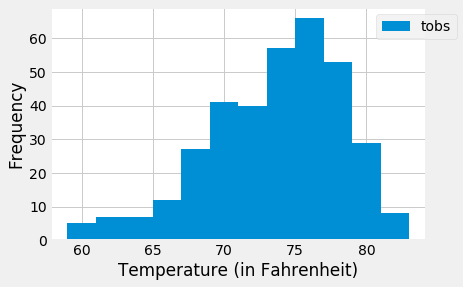

In [139]:
# From the most active station, create a query for the past year and create a histogram of the temperatures

temp_results =session.query(Measurement.date, Measurement.tobs).filter(Measurement.date <= '2017-08-23').\
             filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temp_results, columns = ['date','tobs'])
temp_df = temp_df.set_index('date')
temp_plot = temp_df.plot(kind='hist', bins = 12)
temp_plot.set_xlabel("Temperature (in Fahrenheit)")
temp_plot.legend(bbox_to_anchor=(1.1, 1))
temp_plot.set_facecolor("white")
